In [21]:
import os
import sys
import time
import glob
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from numpy import genfromtxt
from scipy import stats
from scipy import ndimage
from sklearn import linear_model
from sklearn.cluster import KMeans
from ph_scan import *

In [22]:
# -- initialize seed
np.random.seed(234)

In [23]:
fname = 'Delivery/057773250120_01/057773250120_01_P004_MUL/17SEP29170130-M2AS-057773250120_01_P004.TIF'
scan = PhScan(fname)

reading Delivery/057773250120_01/057773250120_01_P004_MUL/17SEP29170130-M2AS-057773250120_01_P004.TIF...
extracting to array...  (extracted in 0.0288329124451s)
rescaling...


In [24]:
img0 = scan.img.transpose(1, 2, 0)
img0.shape

(1412, 2263, 4)

In [25]:
# only include pixels have ndvi larger than 0.3
ndvi = scan.ndvi
mask = ndvi <= 0.3
mask = mask * 1

In [26]:
b = np.repeat(mask[:, :, np.newaxis], 4, axis=2)

In [27]:
array_masked = np.ma.array(img0, mask=b, fill_value=0)
img = array_masked.filled()
img.shape

(1412, 2263, 4)

In [28]:
# -- put this into a shape for clustering
nrow = img.shape[0]
ncol = img.shape[1]
nwav = img.shape[2]
npix = nrow * ncol

In [29]:
# using four features(4 color band) to cluster
data = img.transpose(2, 0, 1).reshape(nwav, nrow * ncol).T
# -- cluster a 5% subset
km = KMeans(5, n_jobs=10)
norm = data - data.mean(1, keepdims=True)
norm /= norm.std(1, keepdims=True) + (norm.std(1, keepdims=True) == 0)

ind_nz = np.where(norm.any(axis=1))[0]
ind = np.random.choice(ind_nz, int(0.05 * npix))
km.fit(norm[ind])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [30]:
labs = np.ones((npix), dtype=float) * 20

In [31]:
# -- predict on whole data set
labs[ind_nz] = km.predict(norm[ind_nz])
labs_img = labs.reshape(nrow, ncol)

In [32]:
# cluster number from 1-5, masked pixel number 0
labs_img = labs_img + 1
labs_img[labs_img == 21] = 0

<function matplotlib.pyplot.show>

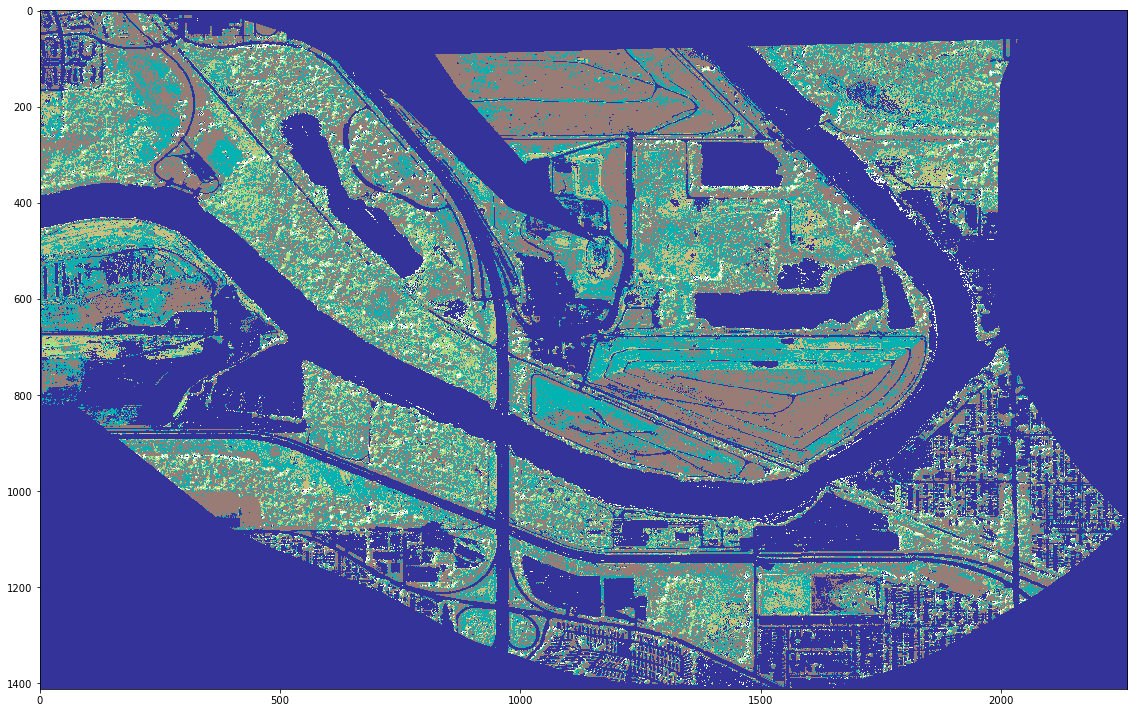

In [33]:
xsize = 20.
ysize = xsize * float(nrow) / float(ncol)
plt.figure(figsize=[xsize, ysize])
fn = fname.split(".")[0]
fn = fn.replace('/', '.')
plt.imshow(labs_img, cmap='terrain')
plt.show
# plt.savefig("cluster_ndvi_0.3/"+fn+".png")

In [34]:
# show the areas larger than 225 pixels for the chosen cluster
def find_cluster(i):
    labs_img_copy = np.copy(labs_img)
    labs_img_copy[labs_img_copy != i] = 0
    label_im, nb_labels = ndimage.measurements.label(labs_img_copy)
    mask_cluster = labs_img_copy > 0
    sizes = ndimage.sum(mask_cluster, label_im, range(0, nb_labels + 1))
    centers = ndimage.measurements.center_of_mass(mask_cluster, label_im, range(0, nb_labels + 1))
    # filter the size
    mask_size = sizes < 225
    centers_filter = [x for x, y in zip(centers, ~mask_size) if y]
    remove_pixel = mask_size[label_im]
    mask_rp = remove_pixel*1
    mask_labs_img = np.ma.array(label_im, mask=mask_rp, fill_value=0)
    labs_img_2 = mask_labs_img.filled()
    labs_img_2 = labs_img_2.astype(float)
    labs_img_2[labs_img_2 == 0] = np.NaN
    
    return labs_img_2, centers_filter

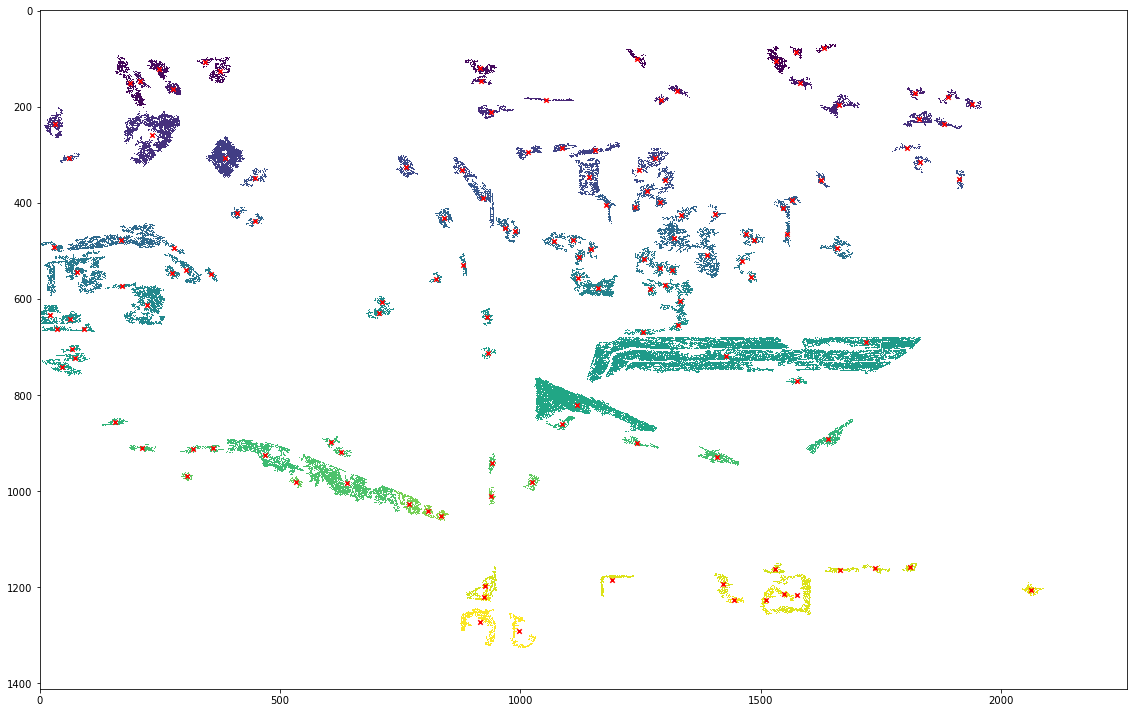

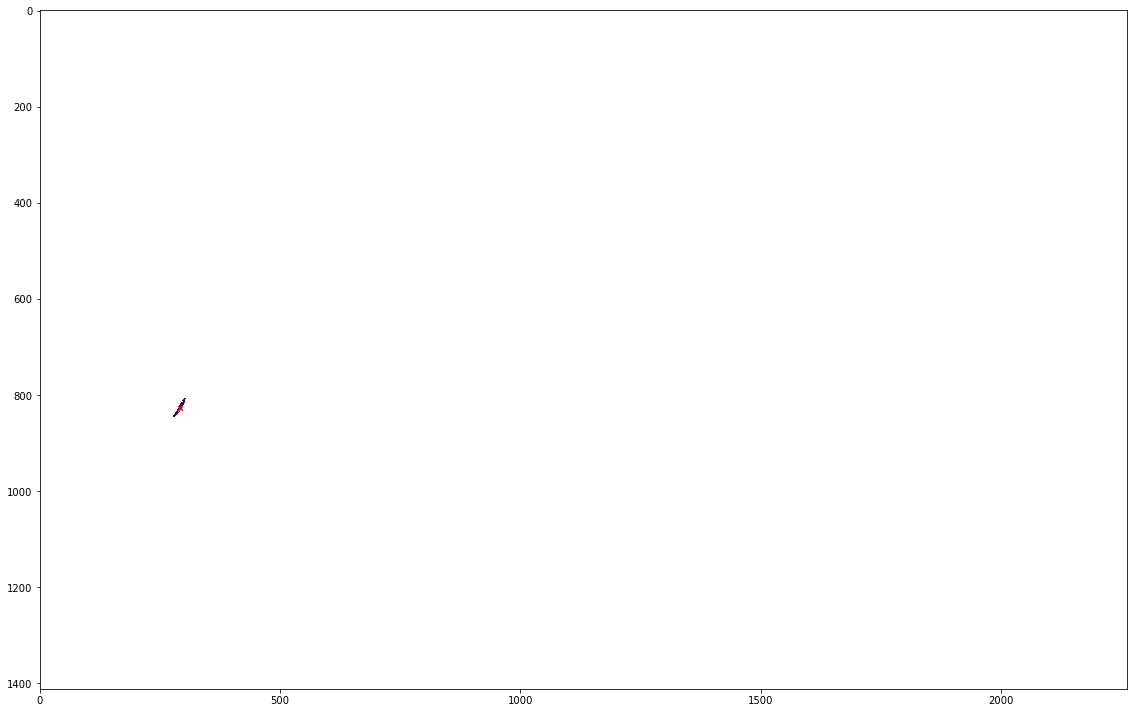

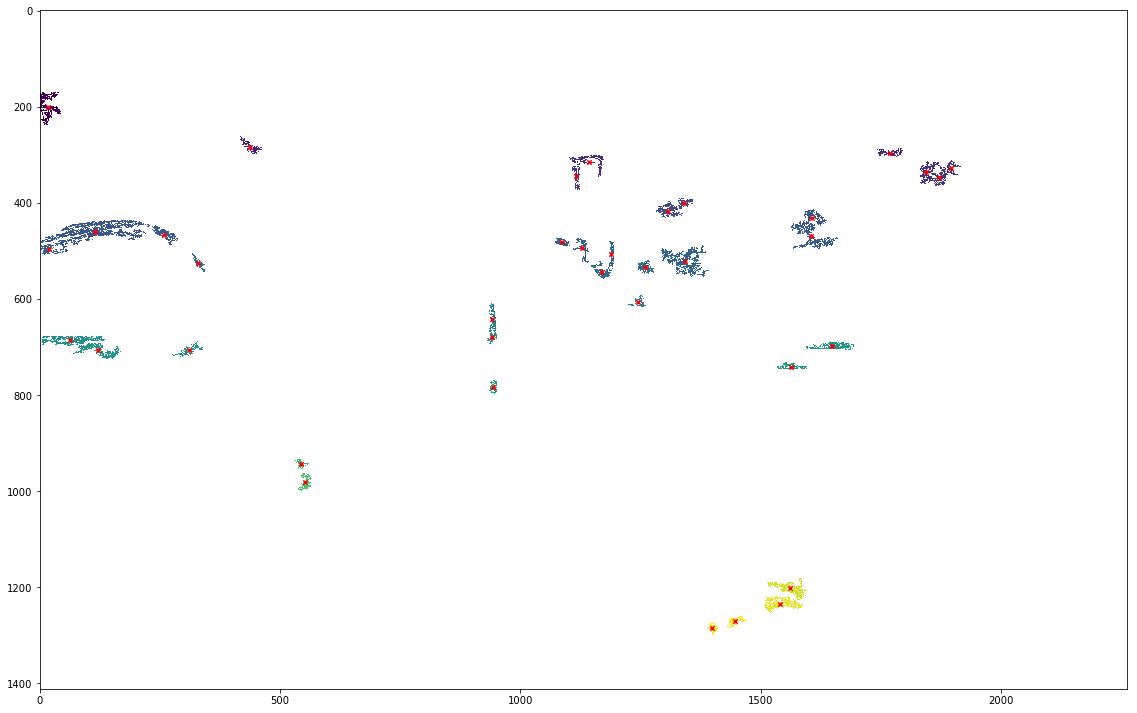

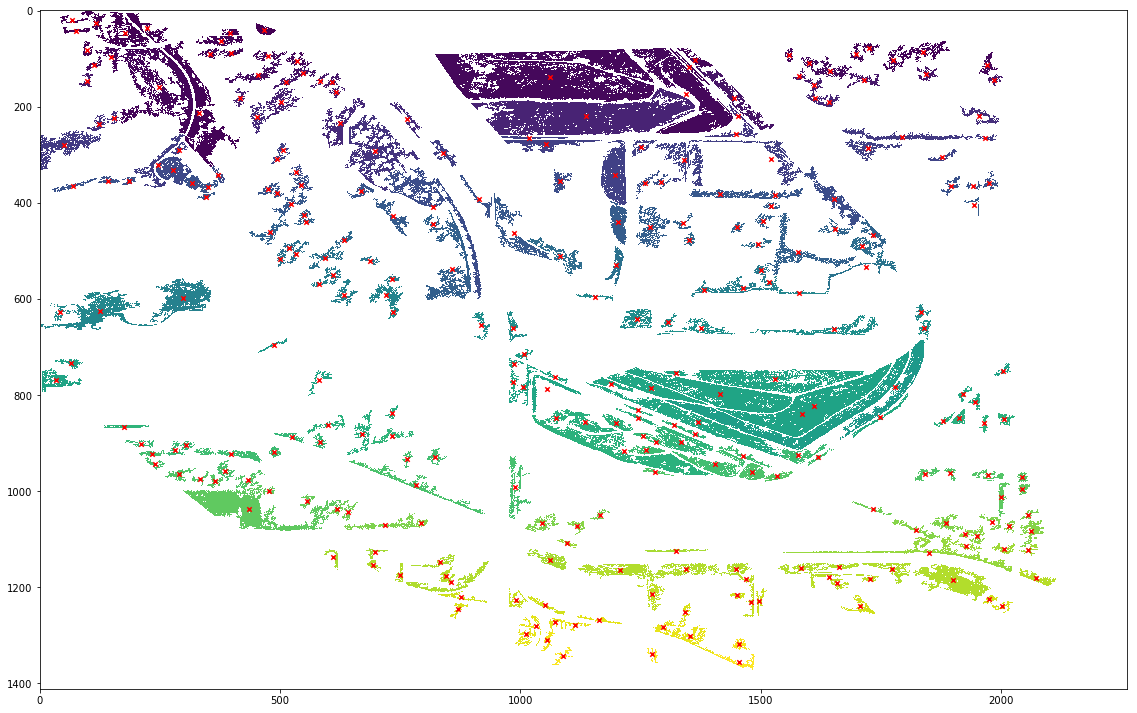

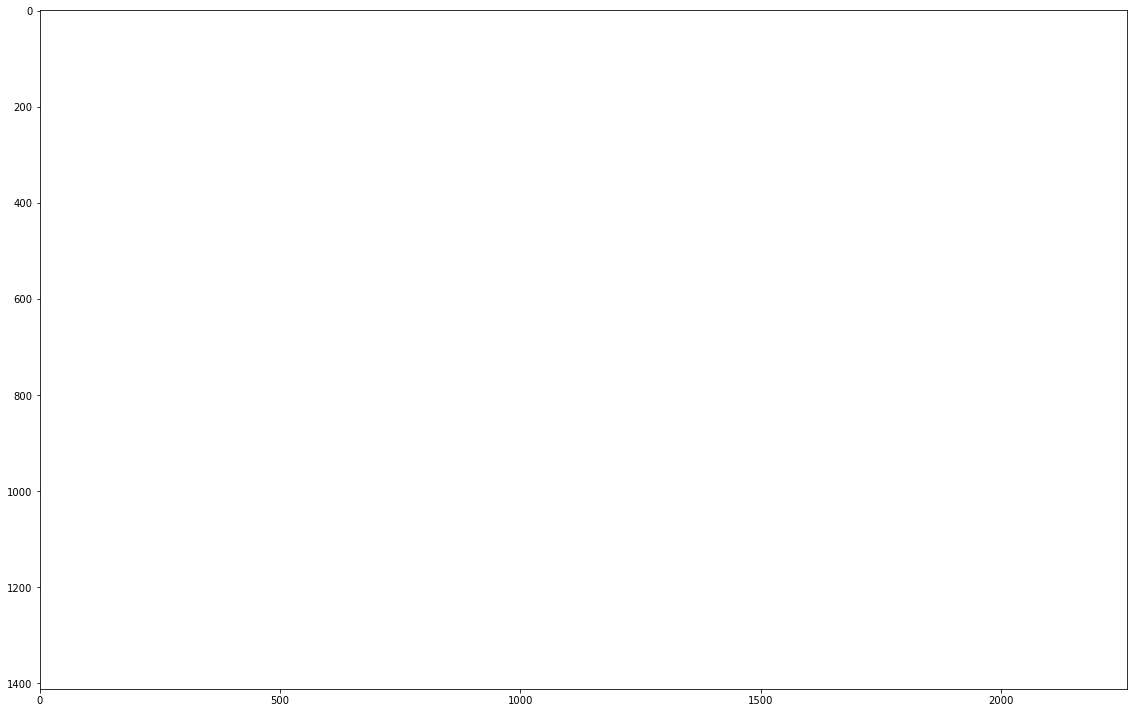

In [35]:
# choose a cluster number
for n in range(1, 6):
    x, y = find_cluster(n)
    xsize = 20.
    ysize = xsize * float(nrow) / float(ncol)
    fig, ax = plt.subplots(figsize=[xsize, ysize])
    for i in range(0, len(y)):
        trow = int(np.round(y[i][0]))
        tcol = int(np.round(y[i][1]))
        ax.scatter([tcol], [trow], c="r", marker="x", s=20)
    plt.imshow(x)
    plt.show
    fn = fname.split(".")[0]
    fn = fn.replace('/', '.')
#     plt.savefig("cluster_ndvi_0.3/"+fn+"cluster"+str(n)+".png") 